In [6]:
import pickle
import os
# Função para imprimir o histórico de treinamento
def print_training_history(history_path):
    with open(history_path, 'rb') as f:
        history_data = pickle.load(f)

    print("\n=== Histórico de Treinamento ===")
    for key, values in history_data.items():
        print(f"{key}:")
        print(f"  Valores por época: {values[:5]} ...")  # Mostra os 5 primeiros valores
        print(f"  Último valor: {values[-1]}\n")

print_training_history("results/training_history.pkl")



=== Histórico de Treinamento ===
iou_metric:
  Valores por época: [0.22663643956184387, 0.39482980966567993, 0.4124729633331299, 0.4196470379829407, 0.40327897667884827] ...
  Último valor: 0.4558452069759369

loss:
  Valores por época: [18.611310958862305, 9.430923461914062, 8.909202575683594, 8.70651626586914, 9.242220878601074] ...
  Último valor: 7.905401706695557

val_iou_metric:
  Valores por época: [0.22205416858196259, 0.3858642578125, 0.34369024634361267, 0.4191852807998657, 0.6076875925064087] ...
  Último valor: 0.6474084854125977

val_loss:
  Valores por época: [19.696475982666016, 9.679129600524902, 9.957446098327637, 8.154370307922363, 4.369863510131836] ...
  Último valor: 3.724196434020996

learning_rate:
  Valores por época: [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05] ...
  Último valor: 9.999999747378752e-05



In [ ]:
import tensorflow as tf
output_dir = 'results/'
model = tf.keras.models.load_model(os.path.join(output_dir, 'model.h5'))

In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

# Criação de diretórios para salvar os resultados
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Função para salvar dados em pickle
def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Função para carregar dados de pickle
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Função para plotar métricas IoU ao longo das épocas
def plot_iou(history, filename):
    plt.figure()
    plt.plot(history['iou_metric'], label='Train IoU')
    plt.plot(history['val_iou_metric'], label='Val IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU Metric Over Epochs')
    plt.savefig(filename)
    plt.show()

def plot_predictions(model, dataset, filename, show=True):
    # Coletar todos os batches
    X_samples, Y_trues = [], []
    for X_batch, Y_batch in dataset:
        X_samples.append(X_batch)
        Y_trues.append(Y_batch)

    # Concatenar todos os batches em um único array
    X_samples = tf.concat(X_samples, axis=0)
    Y_trues = tf.concat(Y_trues, axis=0)

    # Selecionar 5 exemplos aleatórios do conjunto completo
    num_samples = min(len(X_samples), 5)
    indices = np.random.choice(len(X_samples), num_samples, replace=False)

    # Fazer previsões para os exemplos selecionados
    Y_preds = model.predict(tf.gather(X_samples, indices))

    # Criar a figura
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(tf.squeeze(X_samples[idx]), cmap='gray')

        # Plot da bbox verdadeira (verde)
        true_xmin, true_ymin, true_xmax, true_ymax = Y_trues[idx]
        plt.plot([true_xmin, true_xmax, true_xmax, true_xmin, true_xmin],
                 [true_ymin, true_ymin, true_ymax, true_ymax, true_ymin],
                 color='green', label='True BBox')

        # Plot da bbox predita (vermelho)
        pred_xmin, pred_ymin, pred_xmax, pred_ymax = Y_preds[i]
        plt.plot([pred_xmin, pred_xmax, pred_xmax, pred_xmin, pred_xmin],
                 [pred_ymin, pred_ymin, pred_ymax, pred_ymax, pred_ymin],
                 color='red', label='Pred BBox')

        plt.legend()

    plt.savefig(filename)
    if show:
        plt.show()
    plt.close()

# Função para carregar e processar os dados de radar e bbox
def load_radar_bbox_data(base_path, num_samples_per_folder):
    X, Y = [], []
    
    # Lista todas as pastas principais (d1s1, d2s2, etc.)
    main_folders = sorted(glob.glob(os.path.join(base_path, 'd*s*')))
    
    for folder in main_folders:
        subfolders = sorted(glob.glob(os.path.join(folder, '[0-9][0-9][0-9]')))
        
        for subfolder in subfolders:
            radar_files = sorted(glob.glob(os.path.join(subfolder, '*_radar.npz')))
            bbox_files = sorted(glob.glob(os.path.join(subfolder, '*_bbox.npz')))
            
            # Limita o número de amostras a serem carregadas
            selected_indices = np.random.choice(len(radar_files), min(num_samples_per_folder, len(radar_files)), replace=False)
            
            for idx in selected_indices:
                data_radar = np.load(radar_files[idx])
                radar_key = list(data_radar.files)[0]
                data_radar = data_radar[radar_key]
                
                data_bbox = np.load(bbox_files[idx])
                bbox_key = list(data_bbox.files)[0]
                data_bbox = data_bbox[bbox_key]
                data_bbox = data_bbox[:, :4]
                
                X.append(data_radar)
                Y.append(data_bbox)
    
    if len(X) == 0:
        raise ValueError('Nenhum arquivo de radar encontrado. Verifique o caminho dos arquivos.')
    
    X = np.expand_dims(np.array(X).astype(np.float32), axis=-1)
    Y = np.array(Y)
    Y = Y[:, 0, :]
    
    return X, Y

# Definição do caminho base e número de amostras por pasta
base_path = "C:/Users/yukio/Downloads/P1"
num_samples_per_folder = 100  # Defina a quantidade desejada
X, Y = load_radar_bbox_data(base_path, num_samples_per_folder)


train_idx, temp_idx = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Conversão para tf.int32
train_idx = tf.convert_to_tensor(train_idx, dtype=tf.int32)
val_idx = tf.convert_to_tensor(val_idx, dtype=tf.int32)
test_idx = tf.convert_to_tensor(test_idx, dtype=tf.int32)

X_train, X_val, X_test = tf.gather(X, train_idx), tf.gather(X, val_idx), tf.gather(X, test_idx)
Y_train, Y_val, Y_test = tf.gather(Y, train_idx), tf.gather(Y, val_idx), tf.gather(Y, test_idx)

class RadarDataset(tf.data.Dataset):
    def __new__(cls, X, Y):
        dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        return dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    return x, y

def iou_loss(y_true, y_pred):
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.split(y_pred, 4, axis=-1)
    true_xmin, true_ymin, true_xmax, true_ymax = tf.split(y_true, 4, axis=-1)

    inter_xmin = tf.maximum(pred_xmin, true_xmin)
    inter_ymin = tf.maximum(pred_ymin, true_ymin)
    inter_xmax = tf.minimum(pred_xmax, true_xmax)
    inter_ymax = tf.minimum(pred_ymax, true_ymax)

    inter_area = tf.maximum(inter_xmax - inter_xmin, 0) * tf.maximum(inter_ymax - inter_ymin, 0)
    pred_area = tf.maximum(pred_xmax - pred_xmin, 0) * tf.maximum(pred_ymax - pred_ymin, 0)
    true_area = tf.maximum(true_xmax - true_xmin, 0) * tf.maximum(true_ymax - true_ymin, 0)

    union_area = pred_area + true_area - inter_area
    iou = inter_area / (union_area + 1e-7)

    return 1 - tf.reduce_mean(iou)

def iou_metric(y_true, y_pred):
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.split(y_pred, 4, axis=-1)
    true_xmin, true_ymin, true_xmax, true_ymax = tf.split(y_true, 4, axis=-1)

    inter_xmin = tf.maximum(pred_xmin, true_xmin)
    inter_ymin = tf.maximum(pred_ymin, true_ymin)
    inter_xmax = tf.minimum(pred_xmax, true_xmax)
    inter_ymax = tf.minimum(pred_ymax, true_ymax)

    inter_area = tf.maximum(inter_xmax - inter_xmin, 0) * tf.maximum(inter_ymax - inter_ymin, 0)
    pred_area = tf.maximum(pred_xmax - pred_xmin, 0) * tf.maximum(pred_ymax - pred_ymin, 0)
    true_area = tf.maximum(true_xmax - true_xmin, 0) * tf.maximum(true_ymax - true_ymin, 0)

    union_area = pred_area + true_area - inter_area
    iou = inter_area / (union_area + 1e-7)

    return tf.reduce_mean(iou)

def combined_loss(y_true, y_pred):
    return 0.8 * iou_loss(y_true, y_pred) + 0.2 * tf.reduce_mean(tf.keras.losses.Huber()(y_true, y_pred))

def compute_ap(y_true, y_pred):
    """
    Calcula AP50, AP75 e a AP média para detecção de objetos.
    y_true: Tensor de shape (batch, 4) -> [xmin, ymin, xmax, ymax] ground-truth.
    y_pred: Tensor de shape (batch, 4) -> [xmin, ymin, xmax, ymax] predito pelo modelo.
    """
    thresholds = [0.5, 0.75]  # Para AP50 e AP75
    ious = compute_iou(y_true, y_pred)  # Função que calcula IoU
    ap_results = []

    for threshold in thresholds:
        matches = tf.where(ious >= threshold, 1.0, 0.0)  # 1 se IoU >= threshold, senão 0
        precision = tf.reduce_mean(matches)  # Média dos matches
        ap_results.append(precision)

    # AP médio considerando múltiplos thresholds
    mean_ap = tf.reduce_mean(ap_results)

    return {
        "AP50": ap_results[0],
        "AP75": ap_results[1],
        "AP": mean_ap
    }

def compute_iou(y_true, y_pred):
    """
    Calcula Intersection over Union (IoU) para batch de bounding boxes.
    """
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.split(y_pred, 4, axis=-1)
    true_xmin, true_ymin, true_xmax, true_ymax = tf.split(y_true, 4, axis=-1)

    inter_xmin = tf.maximum(pred_xmin, true_xmin)
    inter_ymin = tf.maximum(pred_ymin, true_ymin)
    inter_xmax = tf.minimum(pred_xmax, true_xmax)
    inter_ymax = tf.minimum(pred_ymax, true_ymax)

    inter_area = tf.maximum(inter_xmax - inter_xmin, 0) * tf.maximum(inter_ymax - inter_ymin, 0)
    pred_area = tf.maximum(pred_xmax - pred_xmin, 0) * tf.maximum(pred_ymax - pred_ymin, 0)
    true_area = tf.maximum(true_xmax - true_xmin, 0) * tf.maximum(true_ymax - true_ymin, 0)

    union_area = pred_area + true_area - inter_area
    iou = inter_area / (union_area + 1e-7)  # Pequeno valor para evitar divisão por zero

    return iou

def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=X_train.shape[1:]),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='linear')
    ])
    return model

# Criação dos datasets
dataset_train = RadarDataset(X_train, Y_train).map(augment_data).batch(16).shuffle(buffer_size=100)
dataset_val = RadarDataset(X_val, Y_val).batch(16)
dataset_test = RadarDataset(X_test, Y_test).batch(16)

# Compilação e treinamento do modelo
model = build_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[iou_metric,
        lambda y_true, y_pred: compute_ap(y_true, y_pred)["AP50"],
        lambda y_true, y_pred: compute_ap(y_true, y_pred)["AP75"],
        lambda y_true, y_pred: compute_ap(y_true, y_pred)["AP"]], loss=combined_loss)

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(dataset_train, validation_data=dataset_val, epochs=100, callbacks=[lr_scheduler, early_stopping])

# Avaliação final e salvamento dos resultados
test_loss = model.evaluate(dataset_test)

# Salvar histórico do treinamento, resultados e índices das partições
history_data = history.history
save_pickle(history_data, os.path.join(output_dir, 'training_history.pkl'))
save_pickle(test_loss, os.path.join(output_dir, 'test_loss.pkl'))
save_pickle({'train': train_idx.numpy(), 'val': val_idx.numpy(), 'test': test_idx.numpy()}, os.path.join(output_dir, 'data_indices.pkl'))
model.save(os.path.join(output_dir, 'model.h5'))

print(f"Resultados salvos em {output_dir}")

c:\Users\yukio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - iou_metric: 0.2344 - loss: 14.0658 - val_iou_metric: 0.5149 - val_loss: 5.4958 - learning_rate: 1.0000e-04
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - iou_metric: 0.3311 - loss: 8.9274 - val_iou_metric: 0.5493 - val_loss: 4.7602 - learning_rate: 1.0000e-04
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - iou_metric: 0.3628 - loss: 8.0825 - val_iou_metric: 0.5647 - val_loss: 4.5389 - learning_rate: 1.0000e-04
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - iou_metric: 0.3770 - loss: 7.6530 - val_iou_metric: 0.5831 - val_loss: 4.2851 - learning_rate: 1.0000e-04
Epoch 5/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - iou_metric: 0.3957 - loss: 7.2467 - val_iou_metric: 0.5064 - val_loss: 4.7717 - learning_rate: 1.0000e-04
Epoch 6/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 970s 2s/step - iou_metric: 0.4090 - loss: 6.9446 - val_iou_metric: 0.5578 - val_loss: 4.4848 - learning_rate: 1.0000e-04
Epoch 7/100
610/610 ━━━━━

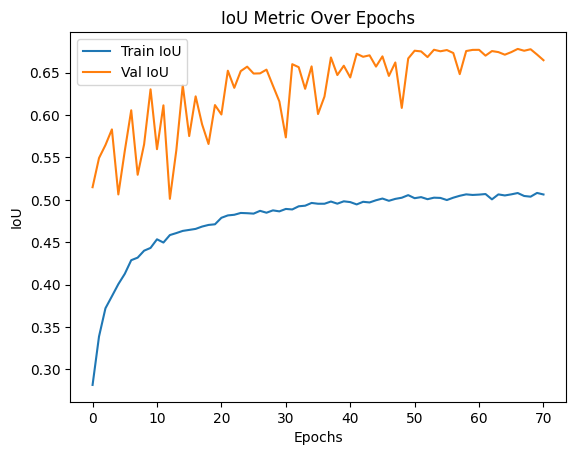

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


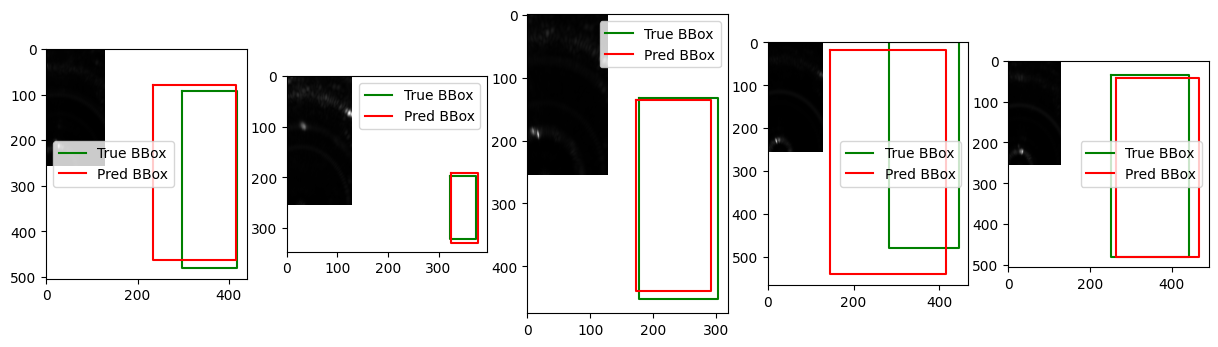

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


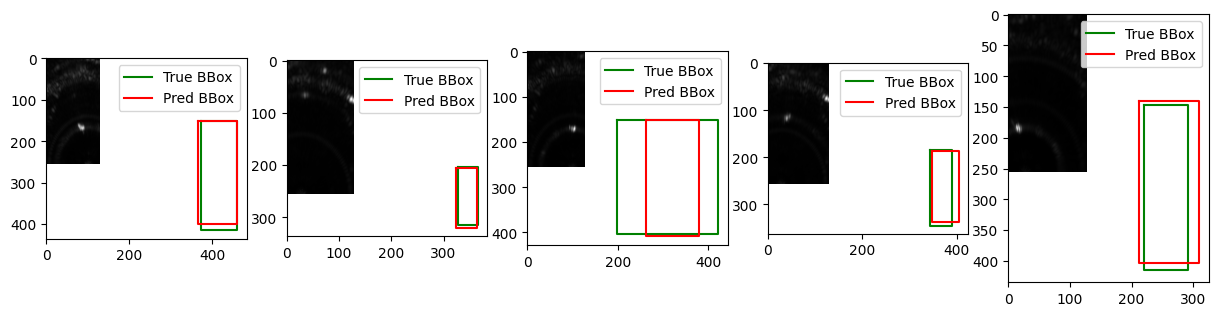

In [3]:
# Gerar plots
plot_iou(history_data, os.path.join(output_dir, 'iou_metric.png'))
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


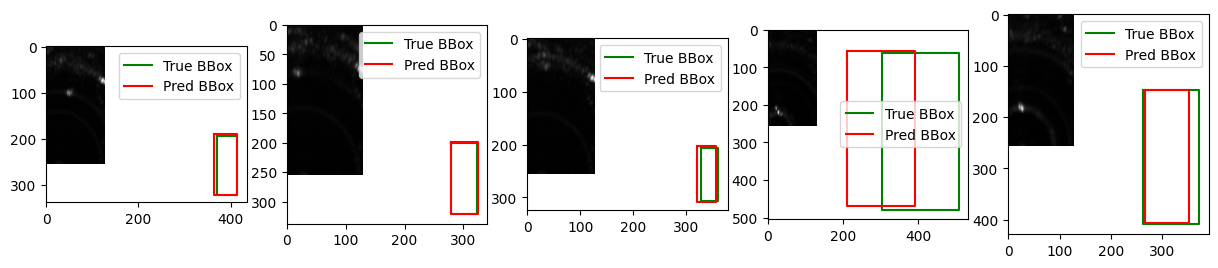

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


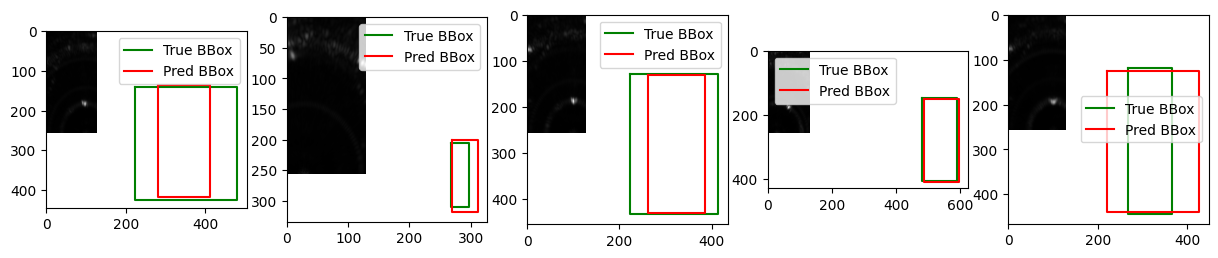

In [4]:
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


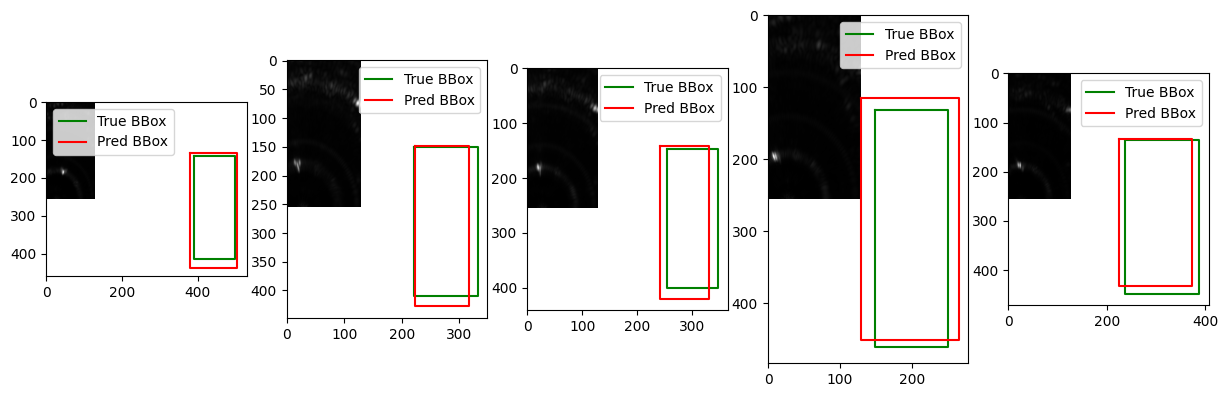

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


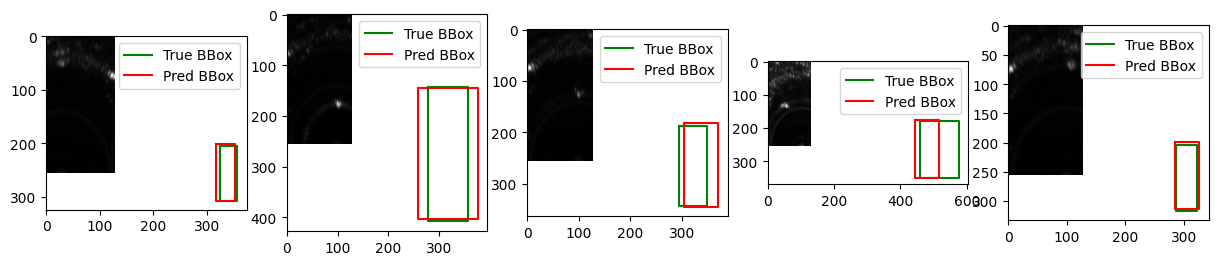

In [5]:
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


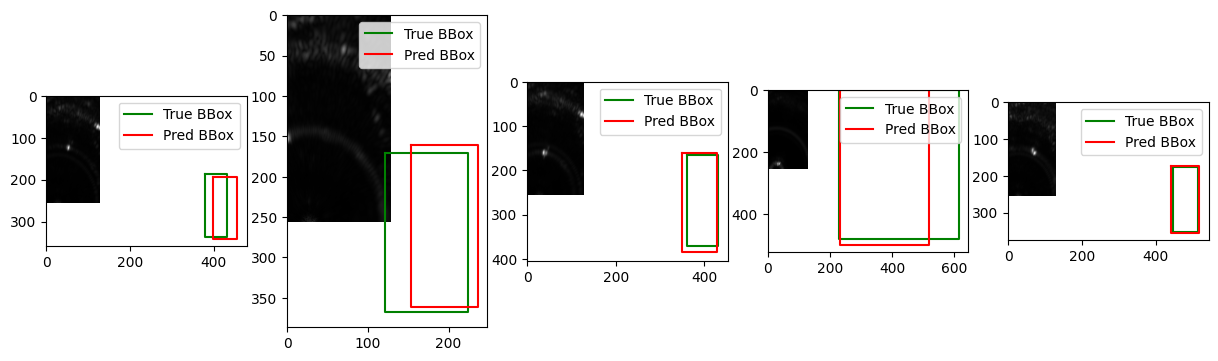

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


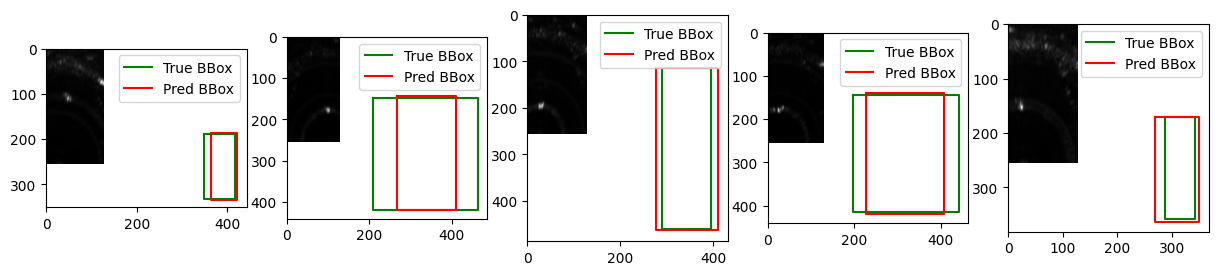

In [6]:
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


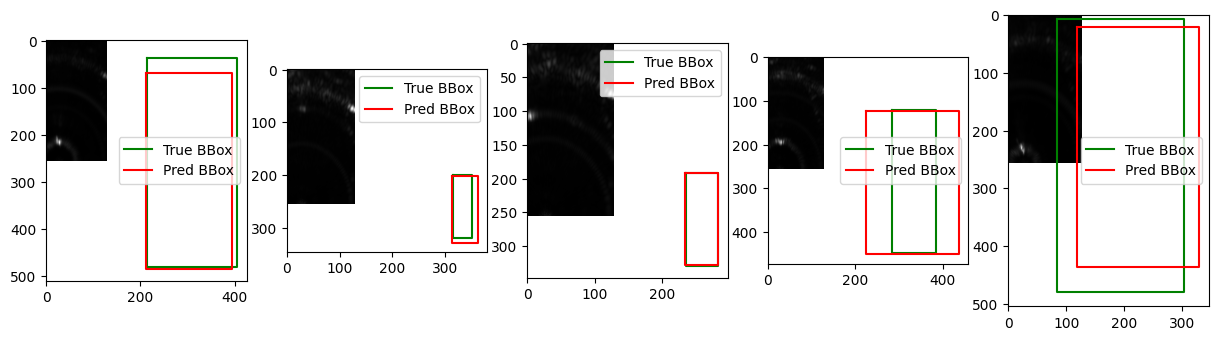

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


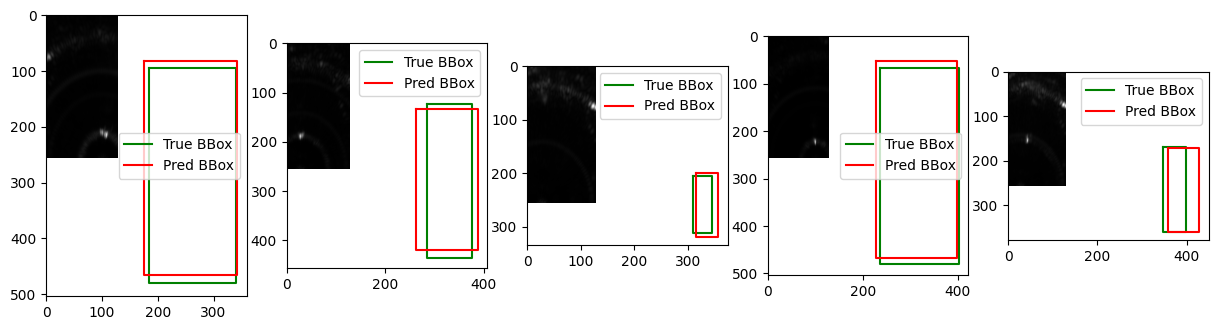

In [7]:
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


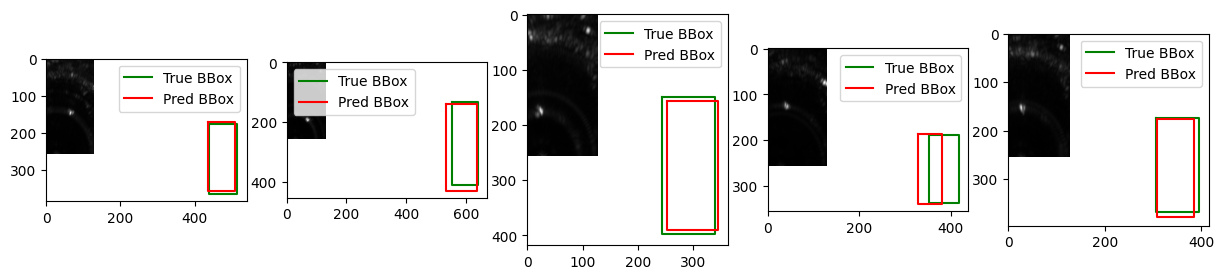

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


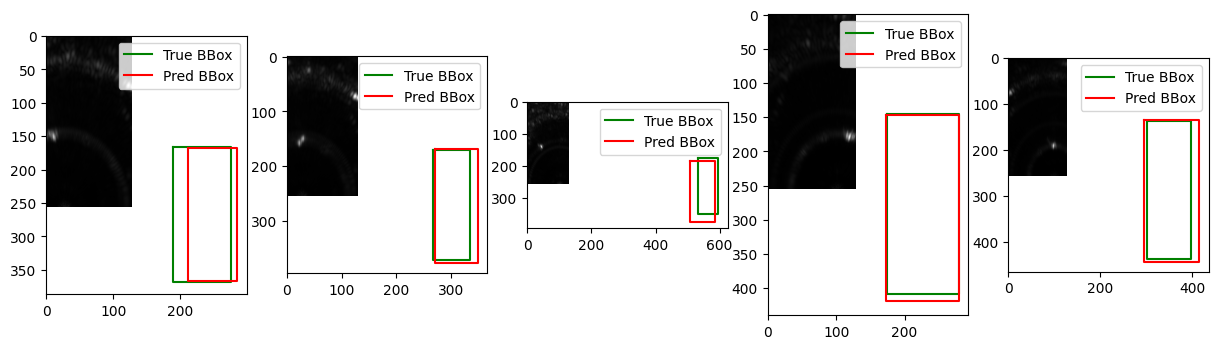

In [8]:
plot_predictions(model, dataset_test, os.path.join(output_dir, 'predictions_comparison.png'), show=True)
plot_predictions(model, dataset_train, os.path.join(output_dir, 'predictions_comparison.png'), show=True)